In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import warnings
warnings.simplefilter('ignore')
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
import os
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()
os.listdir('./data')

['PA_201605-2012001更新R7(20200323).xlsx',
 'pred_0997_all.csv',
 'tag盤點表20200323.xlsx',
 'tag盤點表_cleaned.csv',
 'train_cleaned.csv',
 'train_preprocessed']

In [2]:
tag = pd.read_csv('./data/tag盤點表_cleaned.csv',index_col=0)
tag = tag.loc[tag.category=='可控制因子']

# load X,y

In [3]:
# 2016-05 : 2017-02-17 第一段

In [4]:
data = joblib.load('./data/train_preprocessed')
X = data['X']
Y = data['Y']
x_col = data['x_col']
y_col = data['y_col']
idx = data['idx']
# build df
df = pd.DataFrame(X,index=idx)
df['0997_real'] = Y
print(df.shape)
df.head()

(134620, 575)


,0,1,2,3,4,5,6,7,8,9,...,565,566,567,568,569,570,571,572,573,0997_real
2016-06-01 03:00:00,5695.2363,85.352490,36.090110,34.696857,49.382782,362.26434,144.97864,2.442607,361.02557,60.061237,...,362.24260,144.96265,2.392348,361.03952,60.260216,184.69803,179.80000,364.90765,182.75210,6443.6900
2016-06-01 03:10:00,5709.7036,85.653360,35.959490,35.388890,49.400085,362.33936,144.83496,2.486111,361.09380,60.353172,...,362.23618,144.99008,2.396329,361.01053,60.237118,184.61932,180.03043,364.81244,180.19040,6430.3833
2016-06-01 03:20:00,5687.0700,85.301930,36.018215,34.879738,49.394993,362.22006,145.24248,2.369419,361.02510,61.337530,...,362.24550,145.02303,2.359308,361.05435,60.822850,184.64757,179.91011,364.80770,181.87064,6446.3940
2016-06-01 03:30:00,5689.3900,85.273994,35.984818,35.051820,49.394978,362.19617,145.12143,2.425157,360.96103,60.153100,...,362.21948,144.93568,2.439951,361.00568,60.353374,184.63997,180.20000,364.83188,182.78505,6465.3930
2016-06-01 03:40:00,5695.1797,85.347840,36.002686,34.899242,49.394980,362.21060,144.92728,2.340548,361.02005,60.312088,...,362.21936,145.04015,2.458075,360.98053,60.251034,184.79501,180.20000,364.65503,180.79066,6461.0820


# time_step num_sensor

In [5]:
num_sensor = len(x_col)
time_step = int(X.shape[1]/len(x_col))
print(time_step,num_sensor)

41 14


# select data range

In [6]:
df = df.loc['2016-06-20':'2017-02-20']
idx = df.index
df.head(3).append(df.tail(3))

,0,1,2,3,4,5,6,7,8,9,...,565,566,567,568,569,570,571,572,573,0997_real
2016-06-20 00:00:00,7127.0854,85.40534,35.945026,35.022540,49.497143,355.61044,145.01039,2.710897,354.23960,60.192510,...,355.52545,145.00943,2.644965,354.20547,60.619260,184.06555,176.28226,358.51508,182.41208,7904.0625
2016-06-20 00:10:00,7136.0156,85.43669,36.011635,34.776955,49.480000,355.62457,144.97047,2.729148,354.25500,60.470040,...,355.51508,144.95656,2.569579,354.21500,60.278030,184.14162,176.13545,358.69263,181.79498,7913.4487
2016-06-20 00:20:00,7116.3180,85.14802,35.955723,35.209538,49.485020,355.62590,145.03008,2.790372,354.24045,60.712350,...,355.61456,144.98909,2.690484,354.27950,60.554530,184.01282,176.40000,358.52423,178.33656,7911.7050
2017-02-17 06:00:00,7319.7886,76.99712,35.989002,34.581000,49.497086,346.94998,146.22476,1.709919,346.08005,60.778748,...,346.95000,146.57059,1.660524,346.11940,60.531060,181.40356,171.90000,351.18213,177.66031,8041.7900
2017-02-17 06:10:00,7317.2740,77.02246,35.920265,35.091274,49.505005,346.97995,146.44331,1.752614,346.09670,60.247580,...,346.66315,146.53949,1.471631,345.91745,60.654694,181.55270,171.80660,351.08212,174.84160,8039.3890
2017-02-17 06:20:00,7318.1200,76.99216,36.130260,35.061035,49.505020,346.96830,146.49484,1.646714,346.12830,60.520720,...,345.78055,146.76909,0.466979,345.54070,60.545030,182.09363,171.79341,350.99005,178.14595,8021.1885


# split train test

In [7]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1:]

In [8]:
sp1 = int(len(X)*0.7)
sp2 = int(len(X)*0.85)
X_train,X_valid,X_test = X[:sp1],X[sp1:sp2],X[sp2:]
Y_train,Y_valid,Y_test = Y[:sp1],Y[sp1:sp2],Y[sp2:]
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(22303, 574)
(22303, 1)
(4779, 574)
(4779, 1)
(4780, 574)
(4780, 1)


# plot

In [9]:
t1 = df.iloc[[sp1]].index[0]
t2 = df.iloc[[sp2]].index[0]

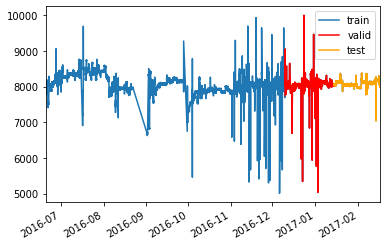

In [10]:
df['0997_real'].plot(label='train')
df['0997_real'][(df.index > t1)&(df.index < t2)].plot(color = 'red',label='valid')
df['0997_real'][(df.index > t2)].plot(color = 'orange',label='test')
plt.legend()
plt.show()

# MinMaxScaler

In [11]:
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler().fit(X)
mm_y = MinMaxScaler().fit(Y)

In [12]:
joblib.dump(mm_x,'./model/mm_x.pkl')
joblib.dump(mm_y,'./model/mm_y.pkl')
print('save done!')

save done!


# scale 

In [13]:
X_train = mm_x.transform(X_train)
X_valid = mm_x.transform(X_valid)
X_test = mm_x.transform(X_test)

Y_train = mm_y.transform(Y_train)
Y_valid = mm_y.transform(Y_valid)
Y_test = mm_y.transform(Y_test)

# torch tensor

In [14]:
import torch

X_train = torch.tensor(X_train).cuda()
X_test = torch.tensor(X_test).cuda()

X_valid = torch.tensor(X_valid).cuda()
Y_valid = torch.tensor(Y_valid).cuda()

Y_train = torch.tensor(Y_train).cuda()
Y_test = torch.tensor(Y_test).cuda()

In [15]:
print(X_train.shape,X_valid.shape,X_test.shape)

torch.Size([22303, 574]) torch.Size([4779, 574]) torch.Size([4780, 574])


# data_iter

In [16]:
train = torch.utils.data.TensorDataset(X_train, Y_train)
valid = torch.utils.data.TensorDataset(X_valid, Y_valid)
train_iter = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=256, shuffle=True)

# Construct the neural network

In [17]:
flat_size = X_train.shape[1]
flat_size,time_step,num_sensor

(574, 41, 14)

In [18]:
class panet(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Sequential(nn.Linear(flat_size,128),nn.Tanh(),nn.Linear(128,time_step))
        self.b = nn.Sequential(nn.Linear(flat_size,128),nn.Tanh(),nn.Linear(128,1))
        self.p = nn.Linear(1,1,bias=False)
        self.history_weight = []
        self.history_b = []
        
    def forward(self,x):
        W = F.softmax(self.w(x),dim=1)
        b = self.b(x)
        feed,factor = self.fetch(x)
        WX = torch.sum(feed*W,dim=1).view(-1,1)
        output = self.p(WX) + b
        self.history_weight.append(W)
        self.history_b.append(b)
        return F.sigmoid(output)
        
    def fetch(self,x):
        x_resize = x.view(-1,time_step,num_sensor)
        feed = x_resize[:,:,0]
        factor = x_resize[:,:,1:]
        factor = factor.reshape(-1,time_step*(num_sensor-1))
        return feed,factor 

In [19]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            torch.nn.init.xavier_uniform(m.weight)
        except:
            pass
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0)
        except:
            pass

In [20]:
net = panet().cuda().double()
net.apply(init_weights)

panet(
  (w): Sequential(
    (0): Linear(in_features=574, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=41, bias=True)
  )
  (b): Sequential(
    (0): Linear(in_features=574, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (p): Linear(in_features=1, out_features=1, bias=False)
)

In [21]:
net(X_test)

tensor([[0.3201],
        [0.3262],
        [0.3283],
        ...,
        [0.3215],
        [0.3223],
        [0.3233]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward>)

# tensorboard

In [22]:
with SummaryWriter(comment='Net')as w:
    w.add_graph(net, (X_test,))

# torchviz

In [23]:
#torchviz.make_dot(net(X_test).mean(),params=dict(net.named_parameters()))

# loss_function and optimizer

In [24]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)
loss_function = nn.MSELoss()

# Training and evaluation

In [25]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    for epoch in range(num_epochs): 
        
        # train model
        net.train()
        train_loss,i = 0,0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            i += 1
        
        # eval model
        with torch.no_grad():
            net.eval()
            val_loss,j = 0,0
            for x, y in valid_iter:
                loss = loss_function(net(x),y)
                val_loss += loss.item()
                j += 1
        
        # caculate avg loss
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            joblib.dump(net,'./model/net.pkl')
            print('model saved')
        
        # record history and print loss of the epoch
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    print('model save at ./model/net.pkl')

model saved
epochs 0 train_avg_loss 0.0054 valid_avg_loss 0.0009
model saved
epochs 1 train_avg_loss 0.0015 valid_avg_loss 0.0009
epochs 2 train_avg_loss 0.0012 valid_avg_loss 0.0010
epochs 3 train_avg_loss 0.0012 valid_avg_loss 0.0010
epochs 4 train_avg_loss 0.0012 valid_avg_loss 0.0009
epochs 5 train_avg_loss 0.0012 valid_avg_loss 0.0009
model saved
epochs 6 train_avg_loss 0.0011 valid_avg_loss 0.0009
epochs 7 train_avg_loss 0.0011 valid_avg_loss 0.0009
epochs 8 train_avg_loss 0.0011 valid_avg_loss 0.0010
epochs 9 train_avg_loss 0.0011 valid_avg_loss 0.0010
model saved
epochs 10 train_avg_loss 0.0011 valid_avg_loss 0.0009
model saved
epochs 11 train_avg_loss 0.0011 valid_avg_loss 0.0009
model saved
epochs 12 train_avg_loss 0.0011 valid_avg_loss 0.0008
epochs 13 train_avg_loss 0.0011 valid_avg_loss 0.0010
epochs 14 train_avg_loss 0.0011 valid_avg_loss 0.0010
model saved
epochs 15 train_avg_loss 0.0011 valid_avg_loss 0.0008
epochs 16 train_avg_loss 0.0011 valid_avg_loss 0.0010
epochs 1

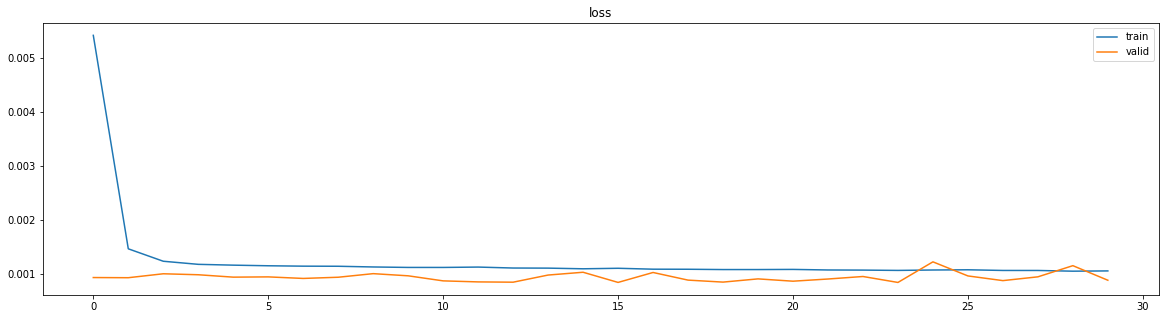

model save at ./model/net.pkl
56.339897871017456


In [26]:
s = time.time()
train(net,train_iter,loss_function,optimizer,num_epochs=30)
print(time.time()-s)

# load best net

In [27]:
net = joblib.load('./model/net.pkl')
net = net.eval()
net

panet(
  (w): Sequential(
    (0): Linear(in_features=574, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=41, bias=True)
  )
  (b): Sequential(
    (0): Linear(in_features=574, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (p): Linear(in_features=1, out_features=1, bias=False)
)

In [28]:
pd.DataFrame(net.history_weight[-1].detach().cpu().numpy()[0]).T.style.background_gradient(axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,0.798988,0.00522063,0.00156367,0.00135548,0.0054639,0.00701596,0.00286207,0.00263462,0.00280271,0.00236057,0.00461417,0.000941147,0.00198506,0.00148032,0.00694498,0.000891689,0.00135265,0.00104898,0.000721277,0.00165768,0.000971277,0.00109854,0.00104177,0.00358114,0.0018668,0.00399159,0.00141296,0.00118827,0.00243276,0.0012028,0.00295303,0.00129535,0.00531765,0.00229513,0.00105343,0.00131536,0.000992324,0.0019806,0.00228028,0.109513,0.00031066


In [47]:
net.p.weight.data

tensor([[0.5518]], device='cuda:0', dtype=torch.float64)

In [48]:
net.history_b[-1].detach().cpu().numpy().mean()

0.0062063727929897086

# metrics

In [31]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100


feed = X.values.reshape(-1,time_step,num_sensor).mean(axis=1)
feed = pd.DataFrame(feed,columns=x_col,index=idx)
feed = feed['MLPAP_FQ-0619.PV']

def show_result(X,Y,index,tag):
    t = pd.DataFrame(index=index)
    t['0619'] = feed[index]
    t['0997_real'] = mm_y.inverse_transform(Y.detach().cpu().numpy().reshape(-1,1)).ravel()
    t['0997_pred'] = mm_y.inverse_transform(net(X).detach().cpu().numpy().reshape(-1,1)).ravel()
    t['單耗_real'] = t['0619']/t['0997_real']
    t['單耗_pred'] = t['0619']/t['0997_pred']
    #t['0997_R2'] = r2_score(t['0997_real'],t['0997_pred'])
    #t['0997_MAPE'] = mape(t['0997_real'],t['0997_pred'])
    t['單耗RMSE'] = sqrt(mean_squared_error(t['單耗_real'],t['單耗_pred']))
    t['單耗MAPE'] = mape(t['單耗_real'],t['單耗_pred'])
    m = t.iloc[[0],-2:]
    m.index = [tag]
    t = t.iloc[:,:-2]
    return t,m

# make prediction(train)

In [32]:
t1,m1 = show_result(X_train,Y_train,idx[:sp1],'train')
m1.head()

,單耗RMSE,單耗MAPE
train,0.020504,1.167836


In [33]:
t1.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred
2016-06-20 00:00:00,7122.090585,7904.0625,7737.955729,0.901067,0.920410
2016-06-20 00:10:00,7121.823454,7913.4487,7765.382543,0.899965,0.917125
2016-06-20 00:20:00,7121.464078,7911.7050,7741.909171,0.900117,0.919859
2016-06-20 00:30:00,7121.265237,7896.0980,7747.413208,0.901871,0.919180
2016-06-20 00:40:00,7121.030054,7889.9550,7778.042125,0.902544,0.915530


# make prediction(valid)

In [34]:
t2,m2 = show_result(X_valid,Y_valid,idx[sp1:sp2],'valid')
m2.head()

,單耗RMSE,單耗MAPE
valid,0.01917,0.946322


In [35]:
t2.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred
2016-12-10 06:50:00,7282.971495,7760.8145,8077.071999,0.938429,0.901685
2016-12-10 07:00:00,7283.010746,7750.1270,8042.084577,0.939728,0.905612
2016-12-10 07:10:00,7283.057739,8307.5700,8078.626444,0.876677,0.901522
2016-12-10 07:20:00,7283.172617,8512.8730,8092.757247,0.855548,0.899962
2016-12-10 07:30:00,7283.275878,8637.8710,8042.634834,0.843180,0.905583


# make prediction(test)

In [36]:
t3,m3 = show_result(X_test,Y_test,idx[sp2:],'test')
m3.head()

,單耗RMSE,單耗MAPE
test,0.007871,0.621174


In [37]:
t3.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred
2017-01-14 18:50:00,7241.010434,8058.298,8040.429168,0.898578,0.900575
2017-01-14 19:00:00,7240.339641,8046.707,8063.480970,0.899789,0.897917
2017-01-14 19:10:00,7239.697924,8040.409,8052.118615,0.900414,0.899105
2017-01-14 19:20:00,7239.238110,8042.686,8034.255427,0.900102,0.901047
2017-01-14 19:30:00,7238.752402,8054.201,8041.495691,0.898755,0.900175


In [38]:
pred_0997_all = t1.append(t2).append(t3)['0997_pred']
pred_0997_all.head()

2016-06-20 00:00:00    7737.955729
2016-06-20 00:10:00    7765.382543
2016-06-20 00:20:00    7741.909171
2016-06-20 00:30:00    7747.413208
2016-06-20 00:40:00    7778.042125
Name: 0997_pred, dtype: float64

In [39]:
pred_0997_all.to_csv('./data/pred_0997_all.csv')
print('save done')

save done
